In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches


def Simple_algorithm(Rey,Bee,Etch):
    B, H, La, L, Re,epsilon = Bee, Etch, 7.5, 18.0, Rey, 1e-03
    Nx,Ny=180,84
    nx,ny=Nx-1,Ny-1
    dx, dy, u_inf =(L/B)/nx, (H/B)/ny, 1

    dt=0.01
    Relaxation=0.1

    icy_s=round(((nx-1)/L)*(La-(B/2)))
    icy_e=round(((nx-1)/L)*(La+(B/2)))
    jcyl_s=round(((ny-1)/H)*((H/2)-(B/2)))
    jcy_e=round(((ny-1)/H)*((H/2)+(B/2)))

    u,v,dp,p=np.zeros([Ny,Nx]),np.zeros([Ny,Nx]),np.zeros([Ny,Nx]),np.zeros([Ny,Nx])
    uc,vc,b_p=np.zeros([Ny,Nx]),np.zeros([Ny,Nx]),np.zeros([Ny,Nx])
    u.fill(u_inf)
    v.fill(0.0)
    p.fill(1.0)

    def Initiate_Coefficient_arrays(kmax):
        b = np.empty([kmax])
        d = np.empty([kmax])
        a = np.empty([kmax])
        c = np.empty([kmax])
        fv = np.empty([kmax])
        return(b,d,a,c,fv)

    def TDMA(b, d, a, c, kmax, fv):
        for k in range(1, kmax):
            d[k] -= b[k] * (a[k-1] / d[k-1])
            c[k] -= b[k] * (c[k-1] / d[k-1])
        fv[kmax-1] = c[kmax-1] / d[kmax-1]
        for k in range(kmax-2, -1, -1):
            fv[k] = (c[k] - a[k] * fv[k+1]) / d[k]

        return fv

    def Bottom_Boundary():
        for i in range(1,nx):
            u[0,i]=-u[1,i]
            v[0,i]=0.0

    def Top_Boundary():
        for i in range(1,nx):
            u[Ny-1,i]= -u[ny-1,i]
            v[ny-1,i]=0.0

    def Left_Boundary():
        for j in range(0,Ny):
            u[j,0]=u_inf
            v[j,0]=-v[j,1]

    def Right_Boundary():
        for j in range(0,Ny):
            u[j,nx-1]=u[j,nx-2]
            v[j,nx]=v[j,nx-1]
            dp[j,nx]=0

    def cylinder_boundary():
        for i in range(icy_s,icy_e-1):
            u[(jcyl_s),i]=-u[jcyl_s-1,i]
            v[(jcyl_s-1),i]=0.0

        for i in range(icy_s,icy_e-1):
            u[(jcy_e-1),i]=-u[jcy_e,i]
            v[(jcy_e-1),i]=0.0

        for j in range(jcyl_s-1,jcy_e):
            u[j,icy_s-1]=0.0
        for j in range(jcyl_s-1,jcy_e):
            v[j,icy_s]=-v[j,icy_s-1]

        for j in range(jcyl_s-1  ,jcy_e):
            u[j,icy_e-1]=0.0
        for j in range(jcyl_s-1,jcy_e):
            v[j,icy_e-1]=-v[j,icy_e]

    au_e=lambda j,i :0.25*(u[j,i]+u[j,i+1])*dy - (dy/(Re*dx))
    au_w=lambda j,i :-0.25*(u[j,i-1]+u[j,i])*dy - (dy/(Re*dx))
    au_n=lambda j,i :0.25*(v[j,i]+v[j,i+1 ])*dx - (dx/(Re*dy))
    au_s=lambda j,i :-0.25*(v[j-1,i]+v[j-1,i+1])*dx - (dx/(Re*dy))
    bu=lambda j,i :(-(dx*dy)/dt)*u[j,i]
    apu=lambda j,i :(p[j,i+1]-p[j,i])*dy
    au=lambda j,i :0.25*(u[j,i]+u[j,i+1])*dy-0.25*(u[j,i-1]+u[j,i])*dy+0.25*(v[j,i]+v[j,i+1 ])*dx-0.25*(v[j-1,i]+v[j-1,i+1])*dx+(dy/(Re*dx))+(dy/(Re*dx))+(dx/(Re*dy))+(dx/(Re*dy))
    av_e=lambda j,i :0.25*(u[j,i]+u[j+1,i])*dy - (dy/(Re*dx))
    av_w=lambda j,i :-0.25*(u[j,i-1]+u[j+1,i-1])*dy - (dy/(Re*dx))
    av_n=lambda j,i :0.25*(v[j,i]+v[j+1,i ])*dx - (dx/(Re*dy))
    av_s=lambda j,i :-0.25*(v[j,i]+v[j-1,i])*dx - (dx/(Re*dy))
    bv=lambda j,i :(-(dx*dy)/dt)*v[j,i]
    apv=lambda j,i :(p[j+1,i]-p[j,i])*dx
    av=lambda j,i :0.25*(u[j,i]+u[j+1,i])*dy-0.25*(u[j,i-1]+u[j+1,i-1])*dy+0.25*(v[j,i]+v[j+1,i ])*dx-0.25*(v[j,i]+v[j-1,i])*dx+(dy/(Re*dx))+(dy/(Re*dx))+(dx/(Re*dy))+(dx/(Re*dy))

    def LBLTDMA_u():
        b,d,a,c,fv=Initiate_Coefficient_arrays(Nx)
        for j in range(1,ny ):
            cylinder_boundary()
            for i in range(1,nx):
                b[0],d[0],a[0],c[0]= 0,1,0,u_inf
                b[-1],d[-1],a[-1],c[-1]=-1,1,0,0
                b[i],d[i],a[i],c[i] = au_w(j,i), au(j,i)+((dx*dy)/dt), au_e(j,i), -bu(j,i)-apu(j,i)-au_s(j,i)*u[j-1,i]-au_n(j,i)*u[j+1,i]
                fv[i]=u[j,i]
            u[j,:] = TDMA(b, d, a, c, Nx, fv)
        Bottom_Boundary()
        Top_Boundary()
        b,d,a,c,fv=Initiate_Coefficient_arrays(Ny)
        for i in range(1, nx):
            for j in range(1, ny):
                b[0],d[0],a[0],c[0]= 0,1,1,0
                b[-1],d[-1],a[-1],c[-1]=1,1,0,0
                b[j],d[j],a[j],c[j] = au_s(j,i), au(j,i)+((dx*dy)/dt), au_n(j,i), -bu(j,i)-apu(j,i)-au_w(j,i)*u[j,i-1]-au_e(j,i)*u[j,i+1]
                fv[j] = u[j,i]
            u[:, i] = TDMA(b, d, a, c, Ny, fv)
        Left_Boundary()
        Right_Boundary()

    def LBLTDMA_v():
        b,d,a,c,fv=Initiate_Coefficient_arrays(Nx)
        for j in range(1,ny):
            cylinder_boundary()
            for i in range(1,nx):
                b[0],d[0],a[0],c[0]= 0,1,1,0
                b[-1],d[-1],a[-1],c[-1]=-1,1,0,0
                b[i],d[i],a[i],c[i] = av_w(j,i), ((dx*dy)/dt)+av(j,i), av_e(j,i), -bv(j,i)-apv(j,i)-av_s(j,i)*v[j-1,i]-av_n(j,i)*v[j+1,i]
                fv[i]=v[j,i]
            v[j,:] = TDMA(b, d, a, c, Nx, fv)
        Bottom_Boundary()
        Top_Boundary()
        b,d,a,c,fv=Initiate_Coefficient_arrays(Ny)
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                b[0],d[0],a[0],c[0]= 0,1,0,0
                b[-1],d[-1],a[-1],c[-1]=1,0,0,0
                b[j],d[j],a[j],c[j] = av_s(j,i), ((dx*dy)/dt)+av(j,i), av_n(j,i), -bv(j,i)-apv(j,i)-av_w(j,i)*v[j,i-1]-av_e(j,i)*v[j,i+1]
                fv[j] = v[j,i]
            v[:, i] = TDMA(b, d, a, c, Ny, fv)
        Left_Boundary()
        Right_Boundary()

    aedp=lambda j,i :dy/( ((dx*dy)/dt)+ au(j,i))
    awdp=lambda j,i :dy/(((dx*dy)/dt)+ au(j,i-1))
    andp=lambda j,i :dx/(((dx*dy)/dt)+ av(j,i))
    asdp=lambda j,i :dx/(((dx*dy)/dt)+ av(j-1,i))
    bp=lambda j,i :-(u[j,i]-u[j,i-1])*dy-(v[j,i]-v[j-1,i])*dx
    adp=lambda j,i :(aedp(j,i)*dy)+(awdp(j,i)*dy)+(andp(j,i)*dx)+(asdp(j,i)*dx)

    def LBLTDMA_dp():
        b,d,a,c,fv=Initiate_Coefficient_arrays(nx-1)
        for j in range(1,ny):
            cylinder_boundary()
            for i in range(1,nx):
                k=i-1
                b[k],d[k],a[k],c[k] = asdp(j,i), adp(j,i), andp(j,i), -bp(j,i)-awdp(j,i)*dp[j,i-1]-aedp(j,i)*dp[j,i+1]
                fv[k]=dp[j,i]
            dp[j,1:nx] = TDMA(b, d, a, c, nx-1, fv)
        Bottom_Boundary()
        Top_Boundary()
        b,d,a,c,fv=Initiate_Coefficient_arrays(ny-1)
        for i in range(1, nx):
            for j in range(1, ny):
                k=j-1
                b[k],d[k],a[k],c[k] = awdp(j,i), adp(j,i), aedp(j,i), -bp(j,i)-asdp(j,i)*dp[j-1,i]-andp(j,i)*dp[j+1,i]
                fv[k]=dp[j,i]
            dp[1:ny, i] = TDMA(b, d, a, c, ny-1, fv)
        Left_Boundary()
        Right_Boundary()

    def dp_gausssiedel():
        for j in range(1,ny):
            for i in range(1,nx):
                dp[j,i]=bp(j,i)/adp(j,i)
    def velocitycorrection():
        for j in range(ny):
            for i in range(nx):
                uc[j,i]=(dy/(((dx*dy)/dt)+ au(j,i))) * (dp[j,i]-dp[j,i+1])
                vc[j,i]=(dx/(((dx*dy)/dt)+ av(j,i)))*(dp[j,i]-dp[j+1,i])
    def SIMPLE():
        LBLTDMA_u()
        LBLTDMA_v()
        dp_gausssiedel()
        velocitycorrection()
        for j in range(1,ny):
            for i in range(1,nx):
                p[j,i]=p[j,i]+(Relaxation*dp[j,i])

        for j in range(1,ny):
            for i in range(1,nx):
                u[j,i]=u[j,i]+uc[j,i]
                v[j,i]=v[j,i]+vc[j,i]
                b_p[j,i]=bp(j,i)

    a=1
    k=1

    while a>epsilon:
        Left_Boundary()
        Right_Boundary()
        Top_Boundary()
        Bottom_Boundary()
        cylinder_boundary()
        SIMPLE()
    #     print(k)
        k=k+1
        a=np.amax(b_p)

    u[jcyl_s-1:jcy_e+1,icy_s-1:icy_e+1]=0
    v[jcyl_s-1:jcy_e+1,icy_s-1:icy_e+1]=0

    #Plotting
    #Grid Generation
    x=np.linspace(dx,(L/B)-dx,nx-1)
    y=np.linspace(dy,(H/B)-dy,ny-1)
    X,Y=np.meshgrid(x,y)
    #Stream Plot
    plt.streamplot(X, Y, u[1:ny, 1:nx], v[1:ny, 1:nx], density=2.75)
    plt.title("Streamplot")
    plt.xlabel("x")
    plt.ylabel("y")

    # Create a rectangle patch with white face color and opaque
    rect = patches.Rectangle((7.5-B/2, H/2-B/2), B, B, linewidth=1, edgecolor='black', facecolor='black', alpha=1)

    # Add the rectangle patch to the plot
    plt.gca().add_patch(rect)

    


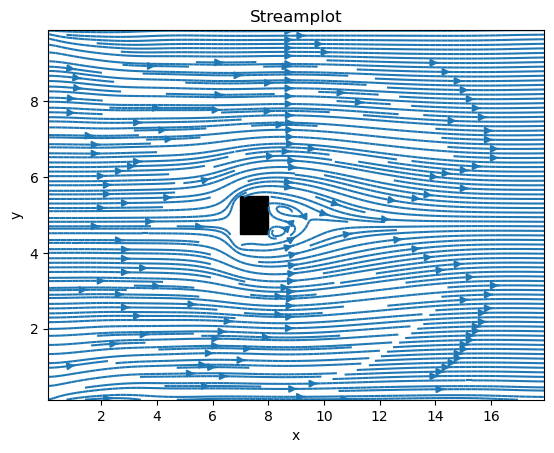

In [27]:
Simple_algorithm(24,1,10)

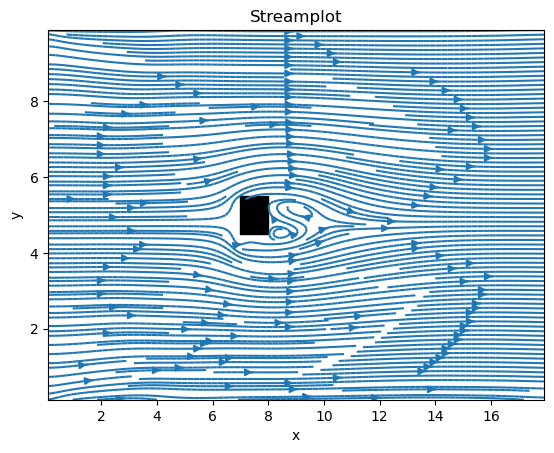

In [28]:
Simple_algorithm(40,1,10)


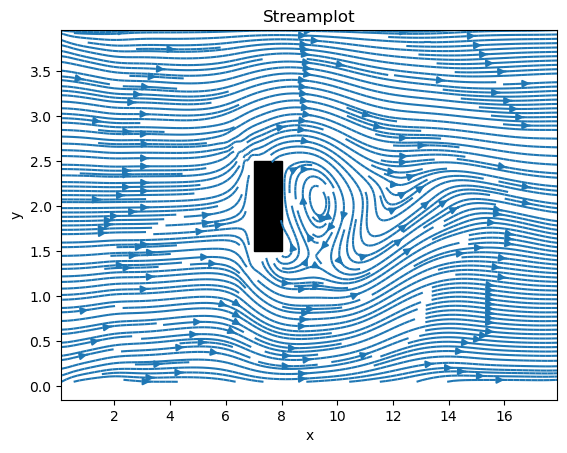

In [29]:
Simple_algorithm(162,1,4)
